# Block Model: Layered background with three blocks

### Characteristics
- **Layered background** can be compared to 1D codes.
- **Simple blockmodel** as benchmark
- The blocks are an **adjusted version of the Dublin Test Model 1** (DTM1), Miensopust et al., 2013. Changes to the model include:
  - Added a layered background (instead of homogeneous background).
  - Converted to a shallow marine scenario, where the airwave is still dominantly present.
  - Layered background contains a shallow, isotropic layer, followed by a slightly
    anisotropic (VTI) background, and a deep strong resistor (e.g., basalt).
  - The blocks are made smaller in size (sort of MT to CSEM adaption):
      - all horizontal distances were divided by a factor of 5,
      - vertical distances by a factor of 20.
- Finite length source with:
  - x1 = [-100, 0, -550]
  - x2 = [100, 0, -550]
  - strength: 800 A  (=> 160 kAm moment)
  - frequency: 1 Hz
  
  
#### References
- Miensopust, M. P., P. Queralt, A. G. Jones, and the 3D MT modellers, 2013, Magnetotelluric 3-D inversion – a review of two successful workshops on forward and inversion code testing and comparison: Geophysical Journal International, 193, 1216–1238; DOI: [10.1093/gji/ggt066](https://doi.org/10.1093/gji/ggt066).

In [1]:
import empymod
import discretize
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook
plt.style.use('ggplot')

## Create the model

### (a) Define the mesh

In [4]:
# Define all the required edges in x, y, and z-directions
hx, x0 = np.array([5500, 4000, 500, 500, 4000, 5500]), -10000
hy, y0 = np.array([6000, 1000, 3000, 3000, 1000, 6000]), -10000
hz, z0 = np.array([250, 50, 1250, 250, 750, 250, 600, 500]), -3400

# Initiate the mesh
mesh = discretize.TensorMesh([hx, hy, hz], x0=np.array([x0, y0, z0]))

# Extract the depths of the layers (extracted from mesh, to ensure they are equal)
depth = np.r_[mesh.vectorNz[1], mesh.vectorNz[-4:-1]][::-1]

print("x-edges:", mesh.vectorNx)
print("y-edges:", mesh.vectorNy)
print("z-edges:", mesh.vectorNz)  # Includes background layers and blocks!
print("depths :", depth)          # Only layers

x-edges: [-10000.  -4500.   -500.      0.    500.   4500.  10000.]
y-edges: [-10000.  -4000.  -3000.      0.   3000.   4000.  10000.]
z-edges: [-3400. -3150. -3100. -1850. -1600.  -850.  -600.     0.   500.]
depths : [    0.  -600.  -850. -3150.]


### (b) Define the resistivity model

In [5]:
# 1.A Initiate the horizontal and vertical resistivity models
resh = np.zeros(mesh.nC)
resv = np.zeros(mesh.nC)

# 1.B Define layered background model
res1d = [1e8, 0.3, 1, 2, 1000]
aniso = [1, 1, 1, np.sqrt(2), 1]
resh[mesh.gridCC[:, 2] > depth[0]] = res1d[0]     # Air
resv[mesh.gridCC[:, 2] > depth[0]] = res1d[0]*aniso[0]**2
resh[mesh.gridCC[:, 2] <= depth[0]] = res1d[1]    # Water
resv[mesh.gridCC[:, 2] <= depth[0]] = res1d[1]*aniso[1]**2
resh[mesh.gridCC[:, 2] <= depth[1]] = res1d[2]    # Overburden
resv[mesh.gridCC[:, 2] <= depth[1]] = res1d[2]*aniso[2]**2
resh[mesh.gridCC[:, 2] <= depth[2]] = res1d[3]    # Background
resv[mesh.gridCC[:, 2] <= depth[2]] = res1d[3]*aniso[3]**2
resh[mesh.gridCC[:, 2] <= depth[-1]] = res1d[-1]  # Basement
resv[mesh.gridCC[:, 2] <= depth[-1]] = res1d[-1]*aniso[-1]**2

# Store as background resistivity
resh_bg = resh.copy()
resv_bg = resv.copy()

# 1.C Add the three blocks
resistivities = [10, 100, 500]  # Resistivities Block 1, 2, and 3
block1 = [ -500,  500, -4000, 4000,  -1600, -850]
block2 = [    0, 5000, -3000,    0,  -1850, -1600]
block3 = [-5000,    0,     0, 3000, -2900, -1600]
for i, block in enumerate([block1, block2, block3]):
    block_i = (
        (mesh.gridCC[:, 0] >= block[0]) & (mesh.gridCC[:, 0] <= block[1]) &
        (mesh.gridCC[:, 1] >= block[2]) & (mesh.gridCC[:, 1] <= block[3]) &
        (mesh.gridCC[:, 2] >= block[4]) & (mesh.gridCC[:, 2] <= block[5])
    )

    resh[block_i] = resistivities[i]
    resv[block_i] = resistivities[i]
    
# Reshape them
resh = resh.reshape(mesh.vnC, order='F')
resv = resv.reshape(mesh.vnC, order='F')
resh_bg = resh_bg.reshape(mesh.vnC, order='F')
resv_bg = resv_bg.reshape(mesh.vnC, order='F')

### (c) Define survey

In [7]:
# Source: x-directed electric dipole of 200 m length, 50 meter above seafloor
src = np.array([-100, 100, 0, 0, -550, -550])
src_c = np.mean(src.reshape(-1, 2), 1)
strength = 800  # 800 A strength => 160 kAm source
freq = 1        # 1 Hz frequency

# 3 Receiver lines
rec_x = np.linspace(-10, 10, 101)*1e3
rec_y = np.array([-3, 0, 3])*1e3
rec_z = -600

### (d) QC

<IPython.core.display.Javascript object>


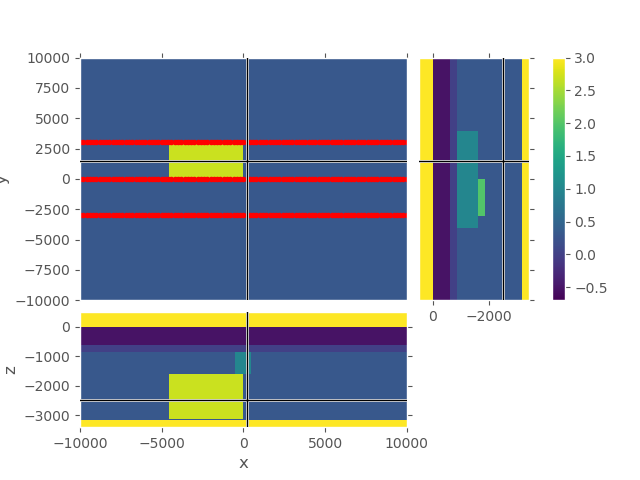

In [16]:
# Plot the resistivity model
fig = plt.figure()

# Horizontal resistivity
mesh.plot_3d_slicer(np.log10(resh), clim=np.log10([0.2, 1000]),
                    zslice=-2500, fig=fig)

# Anisotropy
# mesh.plot_3d_slicer(np.sqrt(resv/resh), zslice=-2500, fig=fig)

axs = fig.get_children()[1]
axs.plot(rec_x, np.ones(rec_x.size)*rec_y[0], 'r.')
axs.plot(rec_x, np.ones(rec_x.size)*rec_y[1], 'r.')
axs.plot(rec_x, np.ones(rec_x.size)*rec_y[2], 'r.')
axs.plot(src_c[0], src_c[1], 'w', lw=3)
plt.show()

## 1D modelling of layered background

In [43]:
rec_X, rec_Y = np.meshgrid(rec_y, rec_x)

epm_1d = empymod.bipole(
    src, [rec_X.ravel(), rec_Y.ravel(), rec_z, 0, 0], depth,
    res1d, freq, aniso=aniso, srcpts=5, strength=strength,
    verb=2, htarg={'pts_per_dec': -1}).reshape(rec_x.size, rec_y.size)

* WARNING :: Offsets < 0.001 m are set to 0.001 m!

:: empymod END; runtime = 0:00:00.023034 :: 5 kernel call(s)



<IPython.core.display.Javascript object>


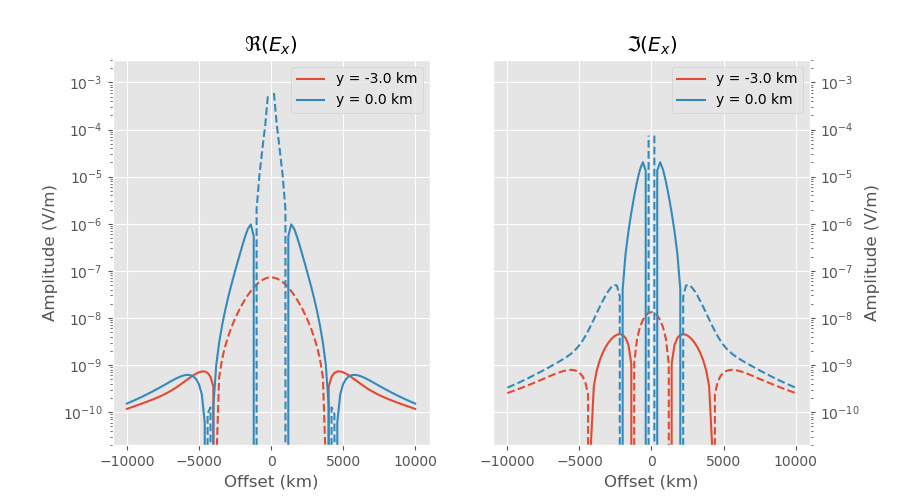

In [45]:
plt.figure(figsize=(9, 5))

# Real
ax1 = plt.subplot(121)
plt.title(r'$\Re(E_x)$')
for i, y in enumerate(rec_y[:2]):
    plt.plot(rec_x, epm_1d[:, i].real, f'C{i}-', label=f'y = {y/1e3} km')
    plt.plot(rec_x, -epm_1d[:, i].real, f'C{i}--')
    
plt.yscale('log')
plt.legend()
plt.xlabel('Offset (km)')
plt.ylabel('Amplitude (V/m)')

# Imaginary
ax2 = plt.subplot(122, sharey=ax1)
plt.title(r'$\Im(E_x)$')
for i, y in enumerate(rec_y[:2]):
    plt.plot(rec_x, epm_1d[:, i].imag, f'C{i}-', label=f'y = {y/1e3} km')
    plt.plot(rec_x, -epm_1d[:, i].imag, f'C{i}--')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.xlabel('Offset (km)')
plt.ylabel('Amplitude (V/m)')

ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')

plt.show()

## 3D modelling with emg3d, layered background

### 1. Create calculation mesh

For the background model, we could get away with a much coarser mesh. However, for simplicity we just use the same mesh for the background model and the full model.

Also, for the 1D model we only calculate the receiver lines for y=0 and y=-3 km, as the result for y=+/-3 km are identical.

In [9]:
# Get cell widths and origin in each direction
xx, x0 = emg3d.utils.get_hx_h0(
    freq=freq, res=[0.3, 1000], fixed=src_c[0], domain=[-4500, 4500], min_width=50)
yy, y0 = emg3d.utils.get_hx_h0(
    freq=freq, res=[0.3, 1000], fixed=src_c[1], domain=[-4000, 4000], min_width=50)
zz, z0 = emg3d.utils.get_hx_h0(
    freq=freq, res=[0.3, 100, 1000], fixed=rec_z, domain=[-3200, 0], min_width=50)

   Skin depth (m/l-r)  [m] : 276 / 15916
   Survey domain       [m] : -4500 - 4500
   Calculation domain  [m] : -99994 - 99994
   Final extent        [m] : -106164 - 106164
   Min/max cell width  [m] : 50 / 50 / 14073
   Alpha survey/calc       : 1.000 / 1.160
   Number of cells (s/c/r) : 256 (180/76/0)

   Skin depth (m/l-r)  [m] : 276 / 15916
   Survey domain       [m] : -4000 - 4000
   Calculation domain  [m] : -99494 - 99494
   Final extent        [m] : -102376 - 102376
   Min/max cell width  [m] : 50 / 50 / 32842
   Alpha survey/calc       : 1.000 / 1.500
   Number of cells (s/c/r) : 192 (160/32/0)

   Skin depth (m/l/r)  [m] : 276 / 5033 / 15916
   Survey domain       [m] : -3200 - 0
   Calculation domain  [m] : -33398 - 95494
   Final extent        [m] : -34774 - 144025
   Min/max cell width  [m] : 50 / 50 / 45428
   Alpha survey/calc       : 1.000 / 1.460
   Number of cells (s/c/r) : 96 (64/31/1)



In [10]:
# Create a TensorMesh instance.
mesh_3d = discretize.TensorMesh([xx, yy, zz], x0=[x0, y0, z0])
mesh_3d

TensorMesh: 4,718,592 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    256   -106,163.67    106,163.67     50.00 14,072.58    1.16
   y    192   -102,376.13    102,376.13     50.00 32,842.04    1.50
   z     96    -34,773.86    144,025.09     50.00 45,427.77    1.46

In [11]:
# Interpolate to new mesh
cresh_3d = 10**emg3d.utils.grid2grid(mesh, np.log10(resh), mesh_3d, 'volume')
cresv_3d = 10**emg3d.utils.grid2grid(mesh, np.log10(resv), mesh_3d, 'volume')
cresh_3d_bg = 10**emg3d.utils.grid2grid(mesh, np.log10(resh_bg), mesh_3d, 'volume')
cresv_3d_bg = 10**emg3d.utils.grid2grid(mesh, np.log10(resv_bg), mesh_3d, 'volume')

# Create model
model_3d = emg3d.utils.Model(mesh_3d, res_x=cresh_3d, res_z=cresv_3d)
model_3d_bg = emg3d.utils.Model(mesh_3d, res_x=cresh_3d_bg, res_z=cresv_3d_bg)

# QC background model
#mesh_3d.plot_3d_slicer(
#    np.log10(model_3d_bg.res_x), #zslice=-2000,
#    xlim=(-10000, 10000),
#    ylim=(-10000, 10000),
#    zlim=(-6000, 500),
#    clim=np.log10([0.2, 200])
#)

### 2. Background calculation

For the background, we only calculate the receiver lines for y=0 and y=-3 km, as the result for y=+/-3 km are identical.

In [12]:
# Source field
sfield_3d = emg3d.utils.get_source_field(mesh_3d, src, freq, strength=strength)

efield_3d_bg = emg3d.solver.solver(
    mesh_3d, model_3d_bg, sfield_3d,
    sslsolver=True,
    semicoarsening=True,
    linerelaxation=True,
    verb=3
)


:: emg3d START :: 13:04:20 ::

   MG-cycle       : 'F'                 sslsolver : 'bicgstab'
   semicoarsening : True [1 2 3]        tol       : 1e-06
   linerelaxation : True [4 5 6]        maxit     : 50 (3)
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 3
   Original grid  : 256 x 192 x  96     => 4,718,592 cells
   Coarsest grid  :   2 x   3 x   3     => 18 cells
   Coarsest level :   7 ;   6 ;   5   

   [hh:mm:ss]  rel. error            solver              MG          l s

       h_
      2h_ \                                        /
      4h_  \                            /\        / 
      8h_   \                  /\      /  \      /  
     16h_    \          /\    /  \    /    \    /   
     32h_     \    /\  /  \  /    \  /      \  /    
     64h_      \/\/  \/    \/      \/        \/     

   [13:06:09]   2.971e-03  after                       1 F-cycles    4 1
   [13:07:44]   3.221e-04  after                       2 F-cycles    5 2
   [13:09:14]   4.595e-05  after  

In [13]:
# Extract (interpolate) Ex-field at receiver locations from the emg3d result.
egd_bg = np.zeros((rec_x.size, 2), dtype=complex)
for i, y in enumerate(rec_y[:2]):
    egd_bg[:, i] = emg3d.utils.get_receiver(mesh_3d, efield_3d_bg.fx, (rec_x, y, rec_z))

<IPython.core.display.Javascript object>


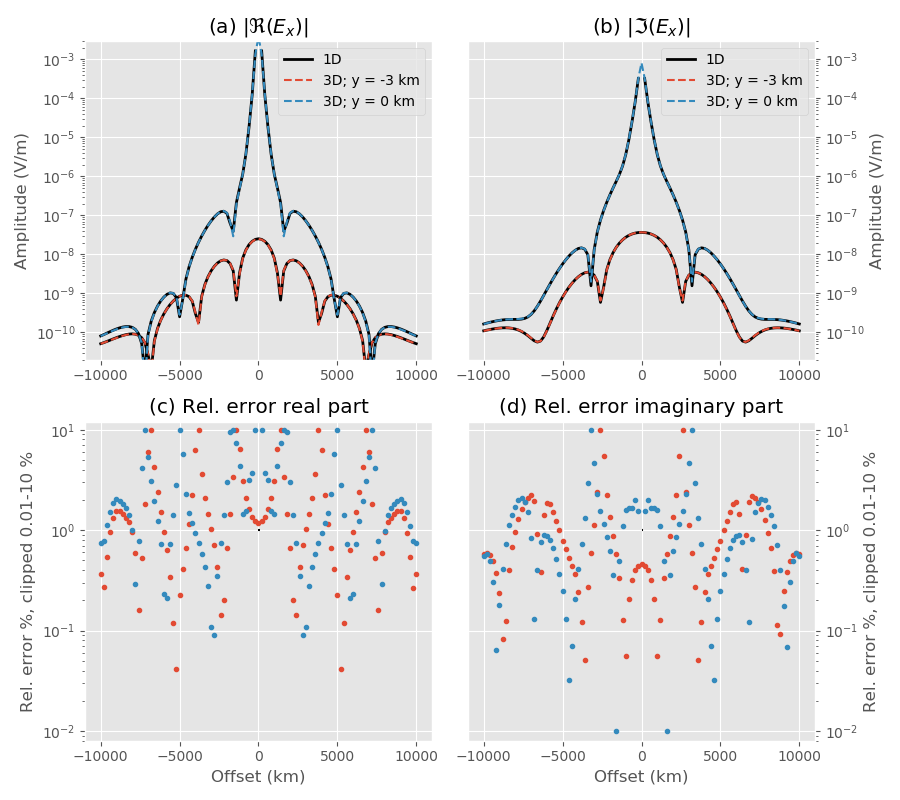

In [14]:
plt.figure(figsize=(9, 8))

# Real
ax1 = plt.subplot(221)
plt.title(r'(a) $|\Re(E_x)|$')
plt.plot(rec_x, abs(epm_1d[:, 0].real), f'k-', lw=2, label=f'1D')
plt.plot(rec_x, abs(egd_bg[:, 0].real), f'C0--', label=f'3D; y = {rec_y[0]/1e3:.0f} km')
plt.plot(rec_x, abs(epm_1d[:, 1].real), f'k-', lw=2)
plt.plot(rec_x, abs(egd_bg[:, 1].real), f'C1--', label=f'3D; y = {rec_y[1]/1e3:.0f} km')
    
plt.yscale('log')
plt.legend()
plt.ylabel('Amplitude (V/m)')

# Imaginary
ax2 = plt.subplot(222, sharey=ax1)
plt.title(r'(b) $|\Im(E_x)|$')

plt.plot(rec_x, abs(epm_1d[:, 0].imag), f'k-', lw=2, label=f'1D')
plt.plot(rec_x, abs(egd_bg[:, 0].imag), f'C0--', label=f'3D; y = {rec_y[0]/1e3:.0f} km')
plt.plot(rec_x, abs(epm_1d[:, 1].imag), f'k-', lw=2)
plt.plot(rec_x, abs(egd_bg[:, 1].imag), f'C1--', label=f'3D; y = {rec_y[1]/1e3:.0f} km')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')

# Real
ax3 = plt.subplot(223)
plt.title('(c) Rel. error real part')

# Calculate error
err = np.clip(100*abs((epm_1d.real-egd_bg.real)/epm_1d.real), 0.01, 10)

plt.plot(rec_x, err[:, 0], 'C0.')
plt.plot(rec_x, err[:, 1], 'C1.')
plt.yscale('log')
plt.hlines(1, 0, 100)
plt.xlabel('Offset (km)')
plt.ylabel('Rel. error %, clipped 0.01-10 %')
plt.ylim([0.008, 12])

# Imaginary
ax4 = plt.subplot(224, sharey=ax3)
plt.title('(d) Rel. error imaginary part')

# Calculate error
err = np.clip(100*abs((epm_1d.imag-egd_bg.imag)/epm_1d.imag), 0.01, 10)

plt.plot(rec_x, err[:, 0], 'C0.')
plt.plot(rec_x, err[:, 1], 'C1.')
plt.yscale('log')
plt.hlines(1, 0, 100)
plt.xlabel('Offset (km)')
plt.ylabel('Rel. error %, clipped 0.01-10 %')
plt.ylim([0.008, 12])

ax4.yaxis.set_ticks_position('right')
ax4.yaxis.set_label_position('right')

plt.tight_layout()
plt.show()

### 3. Full model calculation

In [15]:
# As we use the same mesh, it is the same source field.
efield_3d = emg3d.solver.solver(
    mesh_3d, model_3d, sfield_3d,
    sslsolver=True,
    semicoarsening=True,
    linerelaxation=True,
    verb=3
)


:: emg3d START :: 13:23:55 ::

   MG-cycle       : 'F'                 sslsolver : 'bicgstab'
   semicoarsening : True [1 2 3]        tol       : 1e-06
   linerelaxation : True [4 5 6]        maxit     : 50 (3)
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 3
   Original grid  : 256 x 192 x  96     => 4,718,592 cells
   Coarsest grid  :   2 x   3 x   3     => 18 cells
   Coarsest level :   7 ;   6 ;   5   

   [hh:mm:ss]  rel. error            solver              MG          l s

       h_
      2h_ \                                        /
      4h_  \                            /\        / 
      8h_   \                  /\      /  \      /  
     16h_    \          /\    /  \    /    \    /   
     32h_     \    /\  /  \  /    \  /      \  /    
     64h_      \/\/  \/    \/      \/        \/     

   [13:25:22]   2.974e-03  after                       1 F-cycles    4 1
   [13:26:35]   3.443e-04  after                       2 F-cycles    5 2
   [13:27:52]   6.819e-05  after  

In [16]:
# Extract (interpolate) Ex-field at receiver locations from the emg3d result.
egd = np.zeros((rec_x.size, 3), dtype=complex)
for i, y in enumerate(rec_y):
    egd[:, i] = emg3d.utils.get_receiver(mesh_3d, efield_3d.fx, (rec_x, y, rec_z))

<IPython.core.display.Javascript object>


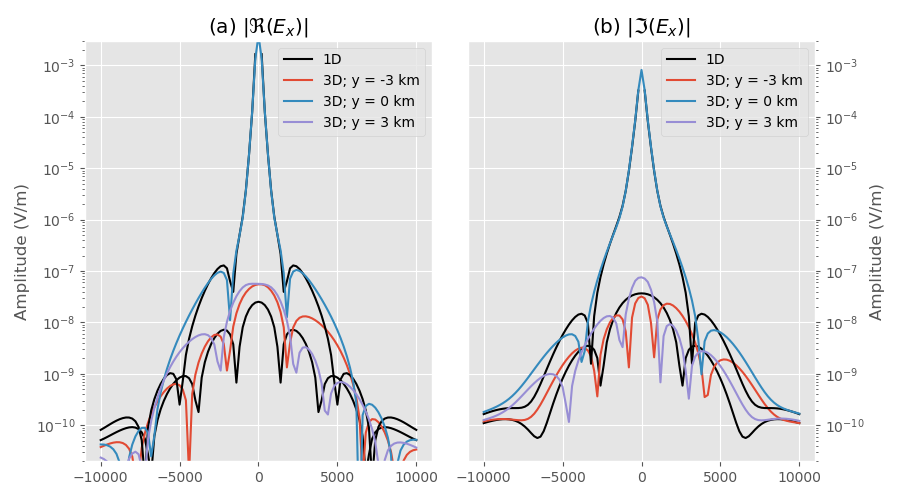

In [17]:
plt.figure(figsize=(9, 5))

# Real
ax1 = plt.subplot(121)
plt.title(r'(a) $|\Re(E_x)|$')

for i, y in enumerate(rec_y):
    if i < 1:
        plt.plot(rec_x, abs(epm_1d[:, i].real), f'k-', label=f'1D')
    elif i < 2:
        plt.plot(rec_x, abs(epm_1d[:, i].real), f'k-')
    plt.plot(rec_x, abs(egd[:, i].real), f'C{i}-', label=f'3D; y = {rec_y[i]/1e3:.0f} km')
    
plt.yscale('log')
plt.legend()
plt.ylabel('Amplitude (V/m)')

# Imaginary
ax2 = plt.subplot(122, sharey=ax1)
plt.title(r'(b) $|\Im(E_x)|$')

for i, y in enumerate(rec_y):
    if i < 1:
        plt.plot(rec_x, abs(epm_1d[:, i].imag), f'k-', label=f'1D')
    elif i < 2:
        plt.plot(rec_x, abs(epm_1d[:, i].imag), f'k-')
    plt.plot(rec_x, abs(egd[:, i].imag), f'C{i}-', label=f'3D; y = {rec_y[i]/1e3:.0f} km')

plt.ylim([2e-11, 3e-3])
plt.legend()
plt.ylabel('Amplitude (V/m)')

ax2.yaxis.set_ticks_position('right')
ax2.yaxis.set_label_position('right')

plt.tight_layout()
plt.show()

## Save data

In [ ]:
np.save('../data/emg3d_results/epm1_1d', epm_1d)
np.save('../data/emg3d_results/egd_bg', egd_bg)
np.save('../data/emg3d_results/egd', egd)

In [18]:
empymod.Report([discretize])

--------------------------------------------------------------------------------
  Date: Tue Oct 29 13:37:19 2019 CET

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           15.5 GB : RAM
           Jupyter : Environment

  Python 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]

            0.4.10 : discretize
            1.17.2 : numpy
             1.3.1 : scipy
            1.10.1 : empymod
             2.7.0 : numexpr
             7.8.0 : IPython
             3.1.1 : matplotlib

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------